<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
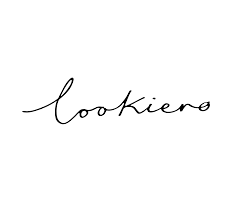    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Link prediction
Se generan multiples redes prediciendo los edges

In [1]:
import pandas as pd
import numpy as np
import pickle

def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df

In [2]:
import warnings
warnings.filterwarnings('ignore')

- **Pyspark**

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col
from pyspark.sql.functions import when

- **Strings**

In [4]:
from collections import Counter

- **Visualización**

In [5]:
import matplotlib.pyplot as plt

* **Grafos**

In [6]:
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx, train_test_split_edges

- **Otros**

In [7]:
import itertools
from itertools import chain

* **Sklearn**

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

import xgboost as xgb
from lightgbm import LGBMRegressor
import catboost as cb
from sklearn.ensemble import RandomForestRegressor

* **Pytorch**

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.utils import to_networkx, from_networkx, train_test_split_edges
import torch.nn as nn

* **Funciones de visualización**

In [10]:
def plotting_results(nombres,  validation, test, x = 0.8):
    X_axis = np.arange(len(nombres))
    fig1, ax1 = plt.subplots(figsize = (27, 8))
    plt.bar(X_axis - 0.1, validation, 0.2, color = colores[0], label = 'Validation')
    plt.bar(X_axis + 0.1, test, 0.2, color = colores[5], label = 'Test')
    plt.ylim(0.6, x)
    plt.xticks(X_axis, nombres)
    plt.xlabel("Modelos", color = 'k', weight = 'bold', fontsize=15)
    plt.title("Resultados de los modelos", color = 'k', weight = 'bold', fontsize=15)
    plt.legend(loc='upper left')
    for p in ax1.patches:
        plt.annotate(format(p.get_height(), '.5f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)

    plt.show()

def plotting_epochs(loss, val_loss, value):
    plt.figure(figsize = (26, 5))
    plt.plot(loss, 'bo', color = '#264653', linewidth = 2, label = 'Train');
    plt.plot(val_loss, color = '#264653', linewidth = 2, label = 'Validation');
    plt.title('Train vs Validation epochs', weight = 'bold', fontsize=15)
    plt.xlabel('Epochs', weight = 'bold', fontsize=15);
    plt.ylabel('Precision', weight = 'bold', fontsize=15);
    plt.text(900, 0.55, str(value), color='black', weight = 'bold', fontsize=15,
        bbox=dict(facecolor=colores[5], edgecolor='black', boxstyle='round,pad=1', alpha=0.8, linewidth=2))

    plt.legend();
    plt.grid(True);
    plt.show();

### Carga de datos
---

In [11]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"
G7, G8, G9 = abrir_pikle('G7'), abrir_pikle('G8'), abrir_pikle('G9')
colores=['#264653','#2A9D8F','#3ECCBB','#E9C46A','#F4A261','#E76F51']

### Generación de features
---

* Embedding manual, es simplemente un one hot enocodding

In [12]:
def generar_one_hot(graph, variables):
    
    for v in variables:
        attr = [graph.nodes[x][v] for x in graph.nodes()]

        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(attr)

        guardar_pikle(label_encoder, graph.name + 'label_encoder_' + v)

        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

        guardar_pikle(onehot_encoded, graph.name +'onehot_encoded_' + v)
        guardar_pikle(onehot_encoder, graph.name + 'onehot_encoder_model_' + v)

In [13]:
variables_usar = ['color','size','level','premium']
for x in [G7, G8, G9]:

    generar_one_hot(x, variables_usar)

    color, size, level, premium = abrir_pikle(x.name + 'onehot_encoded_color'), abrir_pikle(x.name + 'onehot_encoded_size'), abrir_pikle(x.name + 'onehot_encoded_level'), abrir_pikle(x.name + 'onehot_encoded_premium')
    encoding = np.concatenate((color, size, level, premium), axis=1)
    for k, v in enumerate(list(x.nodes())): x.nodes[v]['x'] = encoding[k]	

### Virtual node
---

In [14]:
def virtual_node(graph, variables):
    lista_variables = []
    for v in variables:
        
        aislados = (list(nx.isolates(graph)))
        _model = abrir_pikle(graph.name + 'onehot_encoder_model_' + v)
        labelers = abrir_pikle(graph.name + 'label_encoder_'+ v)

        var = [ graph.nodes[x][v] for x in graph.nodes() if x in aislados ]
        var_numeros = labelers.transform(var)
        integer_encoded = var_numeros.reshape(len(var_numeros), 1)
        onehot_encoded = _model.transform(integer_encoded)

        frecuencias = sum(onehot_encoded) 
        
        guardar_pikle(frecuencias, graph.name + 'frecuencias_' + v)

        feauture_color_virtual_node = [0.0 if x != np.argmax(frecuencias) else 1.0 for x in range(len(frecuencias))]
        lista_variables += feauture_color_virtual_node
        
    return lista_variables

def introduce_VN(graph, variables_VN):

    aislados = (list(nx.isolates(graph)))
    edges_VN = [(x, 'virtual') for x in aislados]

    graph.add_node('virtual', x = np.array(virtual_node(graph, variables_VN)),
        color = '',size  = '',level = '',color_parent = '',printed = '', style = '',premium = '')
    graph.add_edges_from(edges_VN, weight = 1)

In [15]:
introduce_VN(G7, variables_usar)
introduce_VN(G8, variables_usar)
introduce_VN(G9, variables_usar)

### Grafos - Tensores
---

In [16]:
def to_torch_graph(graph):
    G_torch = from_networkx(graph)
    G_torch.x = torch.tensor(G_torch.x, dtype=torch.float32)
    return G_torch

In [17]:
graph_model_7 = to_torch_graph(G7)
graph_model_8 = to_torch_graph(G8)
graph_model_9 = to_torch_graph(G9)

### Model
---

In [18]:
leaky = torch.nn.LeakyReLU()
soft_max = torch.nn.Softmax(dim=1)
sigmoid = torch.nn.Sigmoid()

class Net(torch.nn.Module):
    def __init__(self, out_channels=16, type = 'GCNConv', graph_model = None):
        super(Net, self).__init__()

        if type == 'GCNConv': self.conv1 = GCNConv(np.shape(graph_model.x)[1], out_channels)
        if type == 'SAGEConv': self.conv1 = SAGEConv(np.shape(graph_model.x)[1], out_channels)
        if type == 'GATConv': self.conv1 = GATConv(np.shape(graph_model.x)[1], out_channels)

        self.fc2 = nn.Linear(out_channels * 2, 2)
    
    def encode(self, x, edge_index, activation = 'LeakyReLU'):
        x = self.conv1(x, edge_index) 

        if activation == 'LeakyReLU': activation_funct = torch.nn.LeakyReLU()
        if activation == 'Relu': activation_funct = torch.nn.ReLU()
        if activation == 'Swish': activation_funct = torch.nn.SiLU()

        x = activation_funct(x) 

        return x 

    def forward(self, z): 
        return soft_max(self.fc2(z))

#### **Embedding**

### Train-test split
---

In [19]:
def split_train_test(graph, z, zero_size = 2):

    np.random.seed(42)
    size = len(graph.edges())*zero_size

    G_renamed = nx.relabel_nodes(graph, {v: k for k, v in enumerate(list(graph.nodes()))})
    no_links = list(nx.non_edges(G_renamed))
    np.random.shuffle(no_links)

    embedding_fin = [list(np.concatenate([z[x[0]].detach().numpy(), z[x[1]].detach().numpy()])) for x in list(G_renamed.edges()) ]
    embedding_fin_2 = [list(np.concatenate([z[x[0]].detach().numpy(), z[x[1]].detach().numpy()])) for x in no_links[:size] ]

    embedding_all = embedding_fin + embedding_fin_2
    embedding_fin_torch = torch.tensor(embedding_all, dtype=torch.float32)

    y = [1]*len(embedding_fin) + [0]*len(embedding_fin_2)
    y = torch.tensor(y, dtype=torch.long)

    X_train_full, X_test, y_train_full, y_test = train_test_split(embedding_fin_torch, y, test_size=0.2, random_state=0, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=0, stratify=y_train_full)

    return X_train, X_val, X_test, y_train, y_val, y_test, G_renamed

### **Model Relationship**
---

* Combinaciones de parametros

In [20]:
def combinations_parameters(models = ['GCNConv', 'SAGEConv', 'GATConv'], lr = [0.01, 0.001], activations = ['LeakyReLU', 'Relu', 'Swish'], convolutions = [16, 32]):
    return list(itertools.product(models, lr, activations, convolutions))

parameters = combinations_parameters()

* Funciones de train y test

In [21]:
def train(train_set_x, train_set_y, model, optimizer, criterion):
    model.train()

    optimizer.zero_grad()
    output = model.forward(train_set_x) 
    loss = criterion(output, train_set_y)
    
    loss.backward()
    optimizer.step()

    return loss

@torch.no_grad()
def test(test_set_x, test_set_y, model):

    model.eval()
    total = correct = 0
        
    outputs = model.forward(test_set_x) 
    _, outputs = torch.max(outputs.data, 1)
    total += test_set_y.size(0)
    correct += (outputs == test_set_y).sum().item()
        
    return precision_score(test_set_y, outputs, pos_label = 1, average='binary')  

def epoch_result(epochs, train_set_x, train_set_y, test_set_x, test_set_y, val_set_x, val_set_y, list = False, model = None, optimizer = None, criterion = None):
    
    torch.manual_seed(42)
    np.random.seed(42)

    acumulador = []
    for epoch in range(epochs+1):

        train_loss = train(train_set_x, train_set_y, model, optimizer, criterion)
        value_val, value_test = test(val_set_x, val_set_y, model), test(test_set_x, test_set_y, model)

        if epoch % 50 == 0:  print(f'Epoch: {epoch}, Loss: {train_loss}, Val: {value_val}, Test: {value_test}', end='\r')
        acumulador += [[value_val, value_test]]

    if list == False: return value_val, value_test
    if list == True: return acumulador

def final_train(graph, out_channels, type, learning_rate, activation, epochs = 1000):

    torch.manual_seed(42)
    np.random.seed(42)

    graph_model = to_torch_graph(graph)
    model, data = Net(out_channels = out_channels, type = type, graph_model = graph_model), graph_model
    sc=torch.tensor([1, 0.5])
    criterion = nn.CrossEntropyLoss(weight=sc)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    z = model.encode(graph_model.x, graph_model.edge_index, activation = activation)
    escaler = StandardScaler()
    z = torch.tensor(escaler.fit_transform(z.detach().numpy()), dtype=torch.float32)

    X_train, X_val, X_test, y_train, y_val, y_test, G_renamed = split_train_test(graph, z)
    values = epoch_result(epochs, X_train, y_train, X_test, y_test, X_val, y_val, list = True, model = model, optimizer = optimizer, criterion = criterion)

    return values, model, z, G_renamed, escaler

* Funcion para iterar todos los parametros por grafo

In [22]:
def best_params_graph(graph, parameters, epochs = 300):
    
    graph_model = to_torch_graph(graph)
    final_list, count, soft_max = [], 1, torch.nn.Softmax(dim=1)

    class Net(torch.nn.Module):
        def __init__(self, out_channels=16, type = 'GCNConv', graph_model = graph_model):
            super(Net, self).__init__()

            if type == 'GCNConv': self.conv1 = GCNConv(np.shape(graph_model.x)[1], out_channels)
            if type == 'SAGEConv': self.conv1 = SAGEConv(np.shape(graph_model.x)[1], out_channels)
            if type == 'GATConv': self.conv1 = GATConv(np.shape(graph_model.x)[1], out_channels)

            self.fc2 = nn.Linear(out_channels * 2, 2)
        
        def encode(self, x, edge_index, activation = 'LeakyReLU'):
            x = self.conv1(x, edge_index) 

            if activation == 'LeakyReLU': activation_funct = torch.nn.LeakyReLU()
            if activation == 'Relu': activation_funct = torch.nn.ReLU()
            if activation == 'Swish': activation_funct = torch.nn.SiLU()

            x = activation_funct(x) 

            return x 

        def forward(self, z): 
            return soft_max(self.fc2(z))

    for y in parameters:
        torch.manual_seed(42)
        np.random.seed(42)

        model, data = Net(out_channels = y[3], type = y[0], graph_model = graph_model), graph_model
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters(), lr=y[1])
        
        z = model.encode(graph_model.x, graph_model.edge_index, activation = y[2])
        escaler = StandardScaler()
        z = torch.tensor(escaler.fit_transform(z.detach().numpy()), dtype=torch.float32)

        X_train, X_val, X_test, y_train, y_val, y_test, G_renamed = split_train_test(graph, z)

        value_val, value_test = epoch_result(epochs, X_train, y_train, X_test, y_test, X_val, y_val, list = False, model = model, optimizer = optimizer, criterion = criterion)

        final_list += [[value_val, value_test]]
        print(count, '/', len(parameters), '\n')
        count += 1

    parameters = np.array(parameters)
    final_list = np.array(final_list)

    df_model = pd.DataFrame()
    df_model['Model'], df_model['Learning Rate'], df_model['Activation'], df_model['Convolution'], df_model['Validation'], df_model['Test'] = parameters[:,0], parameters[:,1],  parameters[:,2], parameters[:,3], final_list[:,0], final_list[:,1]
    df_model.sort_values(by = ['Validation'], ascending = False, inplace = True)

    guardar_pikle(df_model, 'df_model_' + str(graph.name))

    return df_model

In [23]:
df_model_9 = best_params_graph(G9, parameters)

* Result

In [23]:
df_model_7 = abrir_pikle('df_model_G7')
df_model_8 = abrir_pikle('df_model_G8')
df_model_9 = abrir_pikle('df_model_G9')

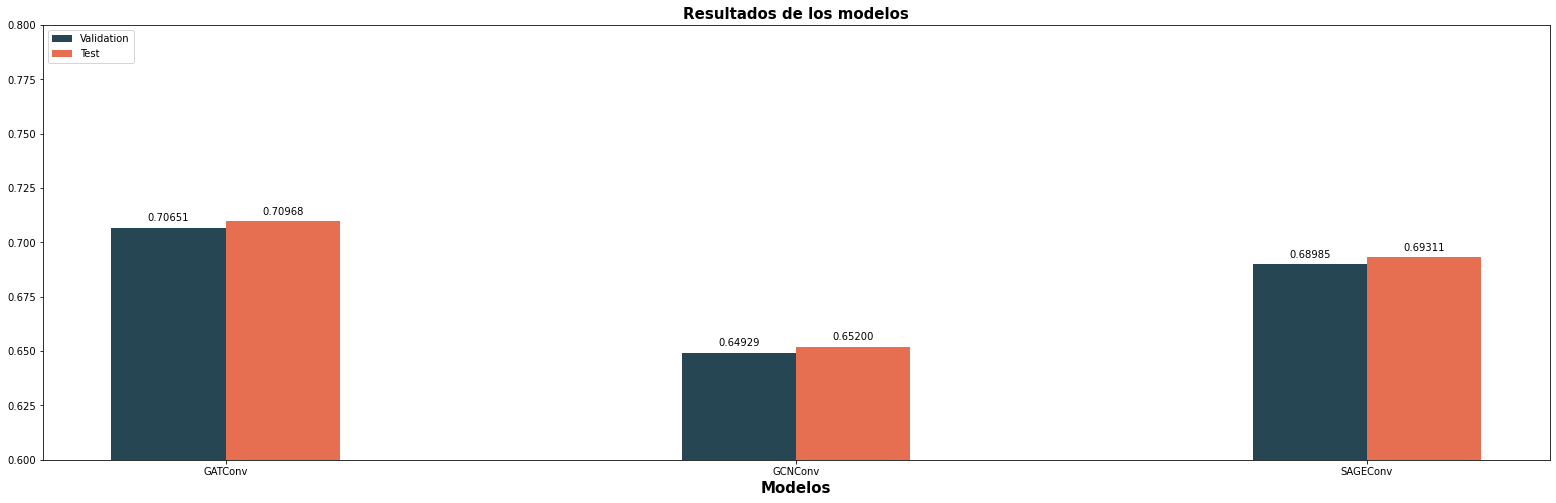

In [26]:
result_7 = df_model_7.groupby(['Model']).agg({'Validation': 'max', 'Test': 'max'})
plotting_results(['GATConv','GCNConv','SAGEConv'],  result_7.Validation, result_7.Test, 0.8)

In [24]:
values_G7, model_G7, embd_G7, G7_renamed, escaler_G7 = final_train(G7, 32, 'GATConv', 0.01, 'Relu', epochs = 1000)

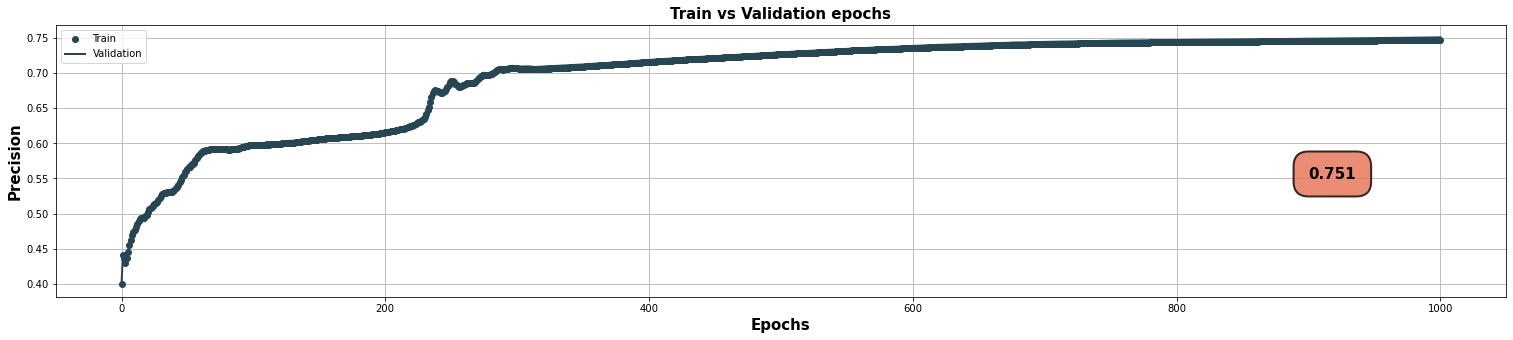

In [32]:
values_G7 = np.array(values_G7)
plotting_epochs(values_G7[:,0], values_G7[:,1], np.round(values_G7[:,1][-1], 3))

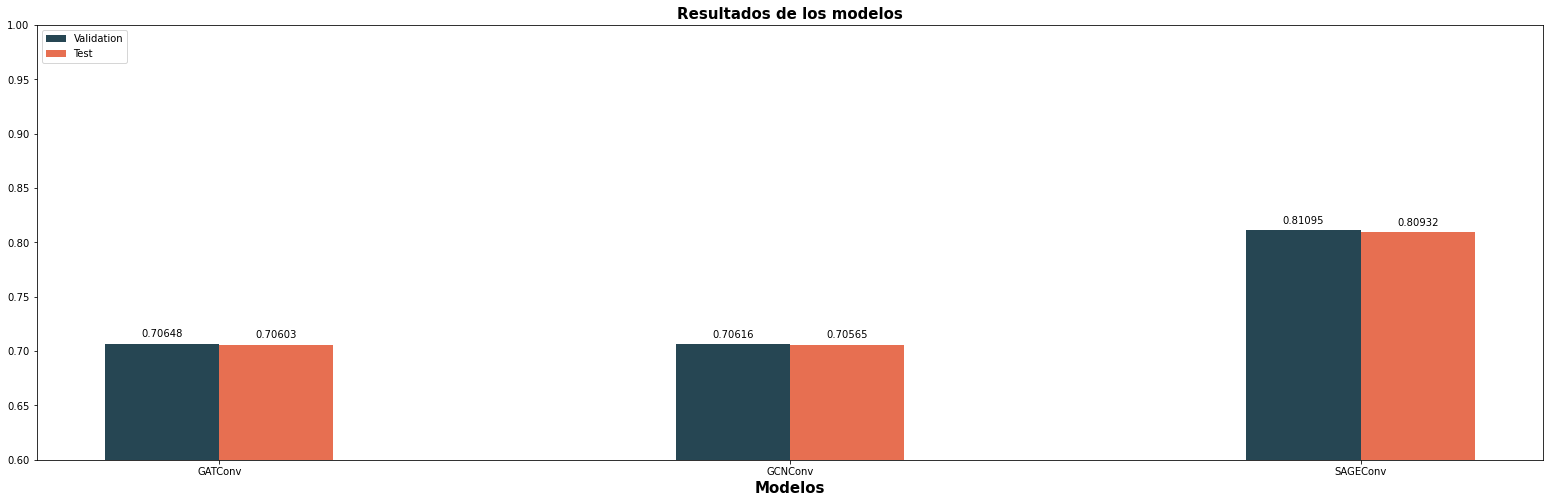

In [34]:
result_8 = df_model_8.groupby(['Model']).agg({'Validation': 'max', 'Test': 'max'})
plotting_results(['GATConv','GCNConv','SAGEConv'],  result_8.Validation, result_8.Test, 1)

In [25]:
values_G8, model_G8, embd_G8, G8_renamed, escaler_G8 = final_train(G8, 32, 'SAGEConv', 0.01, 'LeakyReLU', epochs = 1000)

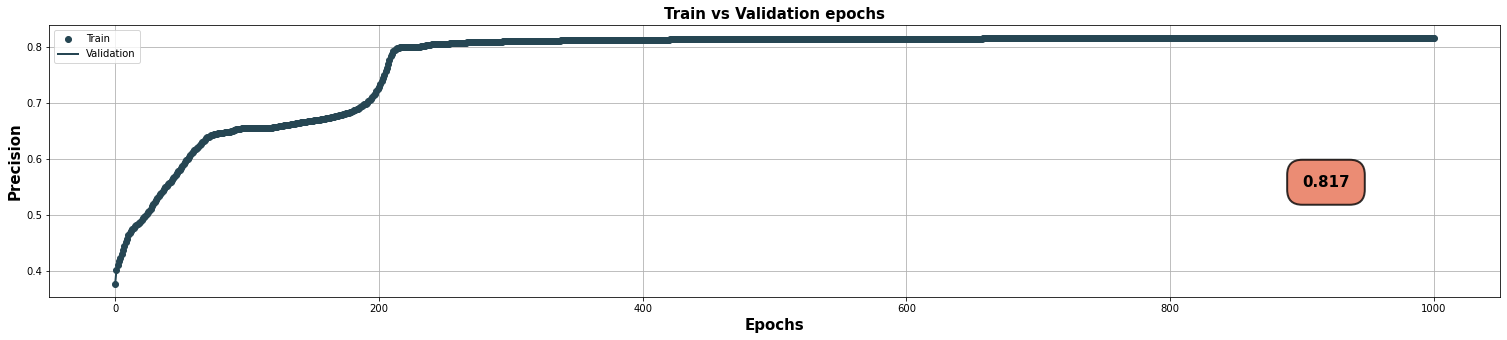

In [25]:
values_G8 = np.array(values_G8)
plotting_epochs(values_G8[:,0], values_G8[:,1], np.round(values_G8[:,1][-1], 3))

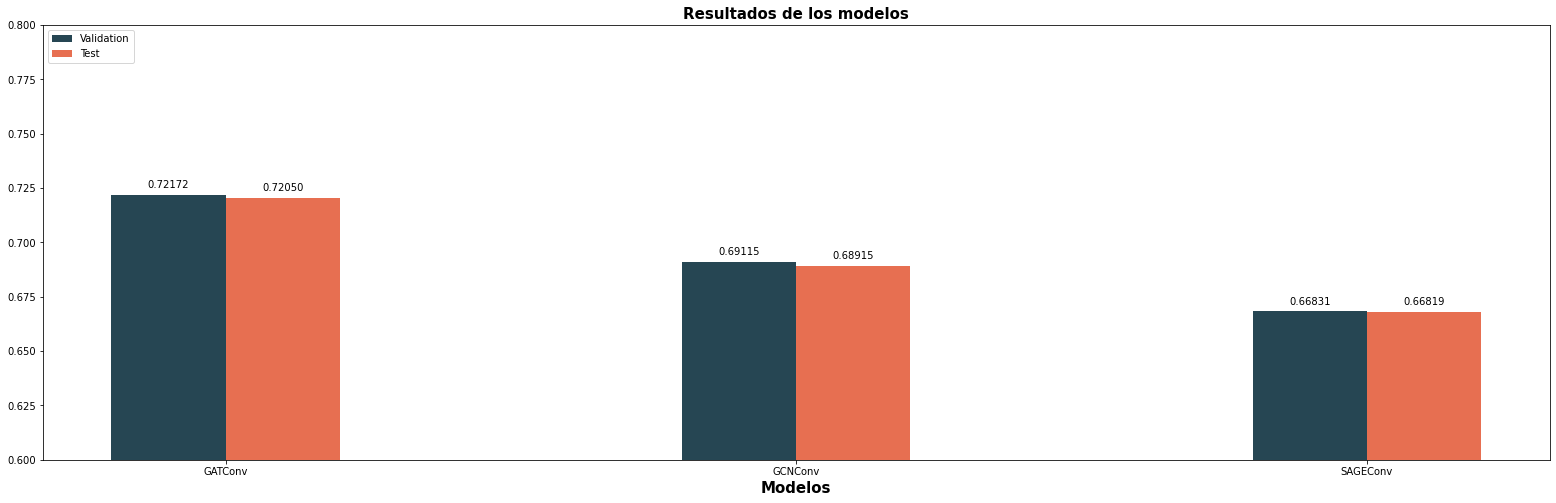

In [35]:
result_9 = df_model_9.groupby(['Model']).agg({'Validation': 'max', 'Test': 'max'})
plotting_results(['GATConv','GCNConv','SAGEConv'],  result_9.Validation, result_9.Test, 0.8)

In [26]:
values_G9, model_G9, embd_G9, G9_renamed, escaler_G9  = final_train(G9, 32, 'GATConv', 0.01, 'Swish', epochs = 1000)

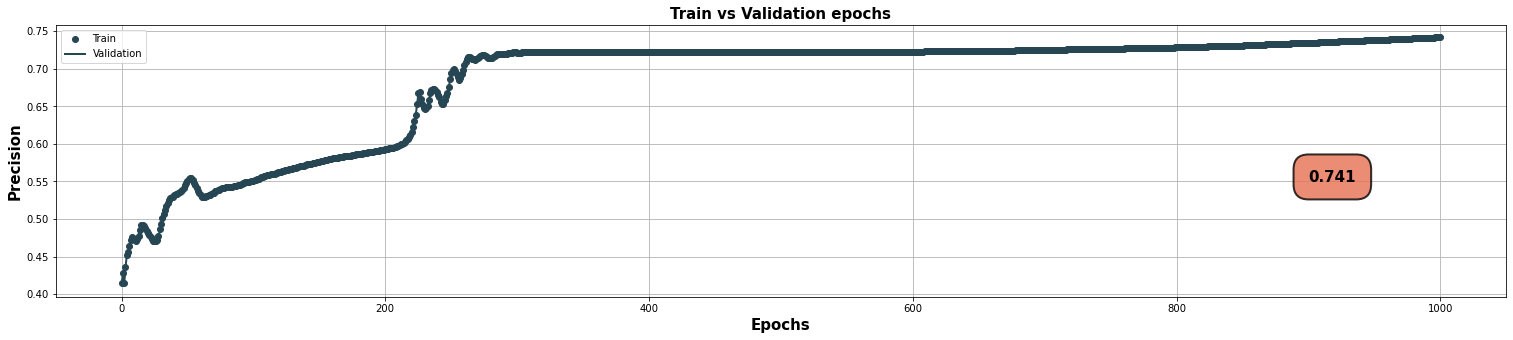

In [37]:
values_G9 = np.array(values_G9)
plotting_epochs(values_G9[:,0], values_G9[:,1], np.round(values_G9[:,1][-1], 3))

* Guardamos los modelos

* Cómo cargar los modelos

In [19]:
model_G7_try = torch.load('model_G7.pt')
model_G7_try.eval()

model_G8_try = torch.load('model_G8.pt')
model_G8_try.eval()

model_G9_try = torch.load('model_G9.pt')
model_G9_try.eval()

Net(
  (conv1): GATConv(69, 32, heads=1)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

### **Model Weight**
---

* Funciones

In [18]:
def train_test(graph, embd = None, type = 'Weight'):

    np.random.seed(42)
    torch.manual_seed(42)
    if type == 'Weight':

        embedding_fin = [list(np.concatenate([embd[x[0]].detach().numpy(), embd[x[1]].detach().numpy()])) for x in list(graph.edges()) ]
        embedding_fin = np.array(embedding_fin)
        pesos = [graph[x[0]][x[1]]['weight'] for x in list(graph.edges()) ]
        X_train, X_test, y_train, y_test = train_test_split(embedding_fin, pesos, test_size=0.2, random_state=0)

    if type == 'Aceptacion':
        if graph.name == 'G7': z = abrir_pikle('z_7')
        if graph.name == 'G8': z = abrir_pikle('z_8')
        if graph.name == 'G9': z = abrir_pikle('z_9')
        embedding_fin = z[:-1]
        aceptaciones = productos_finales.iloc[list(graph.nodes())[:-1],:]
        y = aceptaciones.tasa_aceptacion.values
        
        X_train, X_test, y_train, y_test = train_test_split(embedding_fin.detach().numpy(), y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

def create_graph_model(X_train, y_train, cv = 3):
    xgb_2 = xgb.XGBRegressor(random_state=0)
    lgb = LGBMRegressor(random_state=0, verbosity=0)
    rf = RandomForestRegressor(random_state=0)
    cat = cb.CatBoostRegressor(random_state=0)

    cross_val_xgb = cross_val_score(xgb_2, X_train, y_train, cv=cv)
    cross_val_lgb = cross_val_score(lgb, X_train, y_train, cv=cv)
    cross_val_cat = cross_val_score(cat, X_train, y_train, cv=cv)

    return cross_val_xgb, cross_val_lgb,  cross_val_cat

def procesar_tabla(cross_val_xgb_7, cross_val_lgb_7, cross_val_cat_7, cross_val_xgb_8, cross_val_lgb_8, cross_val_cat_8, cross_val_xgb_9, cross_val_lgb_9, cross_val_cat_9):
    df_weight_models = pd.DataFrame()
    df_weight_models['Model'] = ['XGBoost', 'LightGBM', 'CatBoost']
    df_weight_models['G7 Mean'] = [np.round(np.mean(cross_val_xgb_7), 3), np.round(np.mean(cross_val_lgb_7), 3), np.round(np.mean(cross_val_cat_7), 3)]
    df_weight_models['G7 Std'] = [np.round(np.std(cross_val_xgb_7), 5), np.round(np.std(cross_val_lgb_7), 5), np.round(np.std(cross_val_cat_7), 5)]
    df_weight_models['G8 Mean'] = [np.round(np.mean(cross_val_xgb_8), 3), np.round(np.mean(cross_val_lgb_8), 3), np.round(np.mean(cross_val_cat_8), 3)]
    df_weight_models['G8 Std'] = [np.round(np.std(cross_val_xgb_8), 5), np.round(np.std(cross_val_lgb_8), 5), np.round(np.std(cross_val_cat_8), 5)]
    df_weight_models['G9 Mean'] = [np.round(np.mean(cross_val_xgb_9), 3), np.round(np.mean(cross_val_lgb_9), 3), np.round(np.mean(cross_val_cat_9), 3)]
    df_weight_models['G9 Std'] = [np.round(np.std(cross_val_xgb_9), 5), np.round(np.std(cross_val_lgb_9), 5), np.round(np.std(cross_val_cat_9), 5)]

    return df_weight_models

* Implemetacion

In [39]:
X_train, X_test, y_train, y_test = train_test(G7, embd = embd_G7, type = 'Weight')
cross_val_xgb_7, cross_val_lgb_7, cross_val_cat_7 = create_graph_model(X_train, y_train)
X_train, X_test, y_train, y_test = train_test(G8, embd = embd_G8, type = 'Weight')
cross_val_xgb_8, cross_val_lgb_8, cross_val_cat_8 = create_graph_model(X_train, y_train)
X_train, X_test, y_train, y_test = train_test(G9, embd = embd_G9, type = 'Weight')
cross_val_xgb_9, cross_val_lgb_9, cross_val_cat_9 = create_graph_model(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
Learning rate set to 0.046559
0:	learn: 0.1373846	total: 161ms	remaining: 2m 41s
1:	learn: 0.1371802	total: 165ms	remaining: 1m 22s
2:	learn: 0.1370217	total: 168ms	remaining: 55.7s
3:	learn: 0.1368863	total: 171ms	remaining: 42.6s
4:	learn: 0.1367806	total: 174ms	remaining: 34.6s
5:	learn: 0.1366247	total: 177ms	remaining: 29.3s
6:	learn: 0.1364569	total: 180ms	remaining: 25.5s
7:	learn: 0.1363569	total: 183ms	remaining: 22.8s
8:	learn: 0.1362586	total: 188ms	remaining: 20.6s
9:	learn: 0.1361446	tot

### **Model Tasa envios**
---

* Carga de datos

In [19]:
df_envios = abrir_pikle('df_envios')
df_indices = pd.read_csv(dir_out + 'df_indices.csv')
df_indices['prenda'] = df_indices['0'].apply(lambda x: x.split('_')[0])
df_indices.reset_index(inplace=True)

productos_finales = df_envios.merge(df_indices, left_on='id_variant', right_on='0')
productos_finales['tasa_aceptacion'] = productos_finales['ventas']/productos_finales['envios']
productos_finales.sort_values(by=['index'], ascending=True, inplace=True)
productos_finales.fillna(0, inplace=True)
productos_finales['season'] = productos_finales['id_variant'].apply(lambda x: x.split('_')[3])

* Imprementacion

In [27]:
X_train, X_test, y_train, y_test = train_test(G7, type = 'Aceptacion')
cross_val_xgb_7, cross_val_lgb_7, cross_val_cat_7 = create_graph_model(X_train, y_train)
X_train, X_test, y_train, y_test = train_test(G8, type = 'Aceptacion')
cross_val_xgb_8, cross_val_lgb_8, cross_val_cat_8 = create_graph_model(X_train, y_train)
X_train, X_test, y_train, y_test = train_test(G9, type = 'Aceptacion')
cross_val_xgb_9, cross_val_lgb_9, cross_val_cat_9 = create_graph_model(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
Learning rate set to 0.046559
0:	learn: 0.1373846	total: 170ms	remaining: 2m 49s
1:	learn: 0.1371802	total: 178ms	remaining: 1m 28s
2:	learn: 0.1370217	total: 183ms	remaining: 1m
3:	learn: 0.1368863	total: 187ms	remaining: 46.6s
4:	learn: 0.1367806	total: 191ms	remaining: 38s
5:	learn: 0.1366247	total: 194ms	remaining: 32.2s
6:	learn: 0.1364569	total: 198ms	remaining: 28.1s
7:	learn: 0.1363569	total: 201ms	remaining: 24.9s
8:	learn: 0.1362586	total: 206ms	remaining: 22.7s
9:	learn: 0.1361446	total: 2

In [28]:
procesar_tabla(cross_val_xgb_7, cross_val_lgb_7, cross_val_cat_7, cross_val_xgb_8, cross_val_lgb_8, cross_val_cat_8, cross_val_xgb_9, cross_val_lgb_9, cross_val_cat_9)

,Model,G7 Mean,G7 Std,G8 Mean,G8 Std,G9 Mean,G9 Std
0,XGBoost,-0.269,0.04263,-0.269,0.01837,-0.287,0.02897
1,LightGBM,-0.144,0.03555,-0.166,0.02146,-0.154,0.01125
2,CatBoost,-0.134,0.03774,-0.161,0.01331,-0.132,0.01023


### New nodes
---

* Escogemos estos como si fuesen los nuevos nodos

In [27]:
lista_nodos = list(G8.nodes())
np.random.shuffle(lista_nodos)
nodos_nuevos = [G8.nodes[x]['x'] for x in lista_nodos[:15]]

* Introducimos las nuevas feautes al grafo

In [28]:
nodos_nuevos_torch = torch.tensor(nodos_nuevos, dtype=torch.float32)
new_feautures = torch.cat([graph_model_7.x, nodos_nuevos_torch] )
similitud_coseno = (new_feautures @ new_feautures.t())/(new_feautures.norm(dim=1, keepdim=True) @ new_feautures.norm(dim=1, keepdim=True).t())  

* Se consiguen los nodos contectados y actuales del principio

In [29]:
antiguos_nodos_ailados = ([x[1] for x in G7.edges('virtual')])
nodes_no_aislados = list( set(set(list(G7.nodes())) - set(antiguos_nodos_ailados)) - set('virtual'))

mapeo_nodos, mapeo_inverso = {y:x for x, y in enumerate(G7.nodes())}, {x:y for x, y in enumerate(G7.nodes())}

maped_nodes_aislados = [*map(mapeo_nodos.get, antiguos_nodos_ailados)]
maped_nodes_no_aislados = [*map(mapeo_nodos.get, nodes_no_aislados)]

* Se añaden los nodos nuevos al grafo sin relación ninguna

In [30]:
for k in range(15):
    G7.add_node('new_node' + str(k), x = np.array(new_feautures[graph_model_7.num_nodes - 1 + k]),
    color = '',size  = '',level = '',color_parent = '',printed = '', style = '',premium = '')

* Funciones para añadir nuevos nodos

In [25]:
def actualizar_VN(graph):
    contador1, contador2, lista_variables = 0, 0, []
    for v in variables_usar:
        frecuencias  = abrir_pikle(graph.name + 'frecuencias_' + v)
        valor_aislados = sum([np.array(new_feautures[x]) for x in aislados])

        contador2 += len(frecuencias)
        colores_nuevos_2 = frecuencias + valor_aislados[contador1:contador2]
        contador1 += len(frecuencias)

        feauture_color_virtual_node = [0.0 if x != np.argmax(colores_nuevos_2) else 1.0 for x in range(len(colores_nuevos_2))]
        lista_variables += feauture_color_virtual_node
        
    return lista_variables

def actualizar_G(position, G_renamed):

    muy_similares_no_aislador = set(maped_nodes_no_aislados).intersection(set(aa))
    grado = [G_renamed.degree[x] for x in list(muy_similares_no_aislador)]
    vecinos_al_mas_similar = list(G_renamed.neighbors(list(muy_similares_no_aislador)[np.argmax(grado)]))
    tuplas = [('new_node' + str(position), x) for x in [*map(mapeo_inverso.get, vecinos_al_mas_similar)]]

    return tuplas

def actualizar_G_no_unico(position, G_renamed):
    cc = np.array(similitud_coseno[-15 + position])
    cc = cc[cc != 1]

    pepe = np.where(cc == cc.max())[0]
    pepe = pepe[pepe < graph_model_7.num_nodes]

    grado = [G_renamed.degree[k] for k in list(pepe)]
    vecinos_al_mas_similar = list(G_renamed.neighbors(list(pepe)[np.argmax(grado)]))
    tuplas = [('new_node' + str(position), k) for k in [*map(mapeo_inverso.get, vecinos_al_mas_similar)]]
    
    return tuplas

* Se elige si el nodo nuevo debe de ir conectado con el virtual o con otro

In [33]:
ambos, aislados, no_aislados, ambos_mal,tuplas_acumuladas = [], [], [], [], []
G7_renamed = nx.relabel_nodes(G7, {v: k for k, v in enumerate(list(G7.nodes()))})
for x in range(15):
    aa = list(np.where(similitud_coseno[-15 + x] >= 0.7)[0])
    
    if (len(set(maped_nodes_aislados).intersection(set(aa))) != 0) & (len(set(maped_nodes_no_aislados).intersection(set(aa))) != 0):
        print('Ambos grupos')
        ambos += [-15 + x]
        tuplas_acumuladas += actualizar_G_no_unico(x, G7_renamed)

    elif (len(set(maped_nodes_aislados).intersection(set(aa))) != 0) & (len(set(maped_nodes_no_aislados).intersection(set(aa))) == 0):
        print('Aislados')
        aislados += [-15 + x]

    elif (len(set(maped_nodes_aislados).intersection(set(aa))) == 0) & (len(set(maped_nodes_no_aislados).intersection(set(aa))) != 0):
        print('No aislados')
        no_aislados += [-15 + x]
        tuplas_acumuladas += actualizar_G(x, G7_renamed)

    else:
        print('Ambos grupos - Cuidado')
        ambos_mal += [-15 + x]
        aislados += [-15 + x]
        tuplas_acumuladas += actualizar_G_no_unico(x, G7_renamed)

Ambos grupos
Ambos grupos
Ambos grupos
Ambos grupos
Ambos grupos
Ambos grupos
Ambos grupos
No aislados
Ambos grupos
Ambos grupos
No aislados
No aislados
Ambos grupos
Ambos grupos
No aislados


In [34]:
if len(aislados) != 0:
    G7.nodes['virtual']['x'] = np.array(actualizar_VN(G7))
    tuplas_virtuales = [('virtual', 'new_node' + str(15 + x)) for x in aislados]
else: tuplas_virtuales = []

* Se añaden los nuevos ejes

In [35]:
G7_copy = G7.copy()
G7_copy.add_edges_from(tuplas_virtuales + tuplas_acumuladas, weight = 1)
net_torch = to_torch_graph(G7_copy)

* Se generan los embedding con los nuevos vecindarios artificiales

In [37]:
new_emb = model_G7_try.encode(net_torch.x, net_torch.edge_index)

* Se predice los links para cada uno de los nuevos nodos

In [39]:
z = model_G7_try.encode(graph_model_7.x, graph_model_7.edge_index)
escaler = StandardScaler()
z = torch.tensor(escaler.fit_transform(z.detach().numpy()), dtype=torch.float32)

* De todos los embeddings de seleccionan los ultimos, es decir, los nodos nuevos

In [41]:
escalados = torch.tensor(escaler.transform(new_emb[-15:].detach().numpy()), dtype=torch.float32)
tuplas_nuevas = []
for k in range(15):
    repetition = escalados[k].repeat(len(z), 1)
    pred_vector = torch.cat([repetition, z], dim = -1)

    y_pred = model_G7_try.forward(pred_vector)
    _, y_pred = torch.max(y_pred, 1)
    tuplas_nuevas += [('new_node'+ str(k), x) for x in np.where(np.array(y_pred) == 1)[0]]

* Muestra de nuevas tuplas

In [42]:
print(tuplas_nuevas[:100])

[('new_node0', 2), ('new_node0', 7), ('new_node0', 11), ('new_node0', 21), ('new_node0', 31), ('new_node0', 33), ('new_node0', 35), ('new_node0', 39), ('new_node0', 41), ('new_node0', 42), ('new_node0', 47), ('new_node0', 50), ('new_node0', 51), ('new_node0', 53), ('new_node0', 61), ('new_node0', 62), ('new_node0', 64), ('new_node0', 69), ('new_node0', 72), ('new_node0', 74), ('new_node0', 75), ('new_node0', 85), ('new_node0', 86), ('new_node0', 87), ('new_node0', 88), ('new_node0', 95), ('new_node0', 109), ('new_node0', 118), ('new_node0', 130), ('new_node0', 136), ('new_node0', 141), ('new_node0', 147), ('new_node0', 148), ('new_node0', 176), ('new_node0', 190), ('new_node0', 192), ('new_node0', 199), ('new_node0', 204), ('new_node0', 217), ('new_node0', 226), ('new_node0', 228), ('new_node0', 241), ('new_node0', 244), ('new_node0', 249), ('new_node0', 252), ('new_node0', 255), ('new_node0', 261), ('new_node0', 268), ('new_node0', 270), ('new_node0', 274), ('new_node0', 276), ('new_n

---